# Taller Final AA3.
    Estudiante: Juan Sebastian Orozco Hernandez
    ID: 1017173516

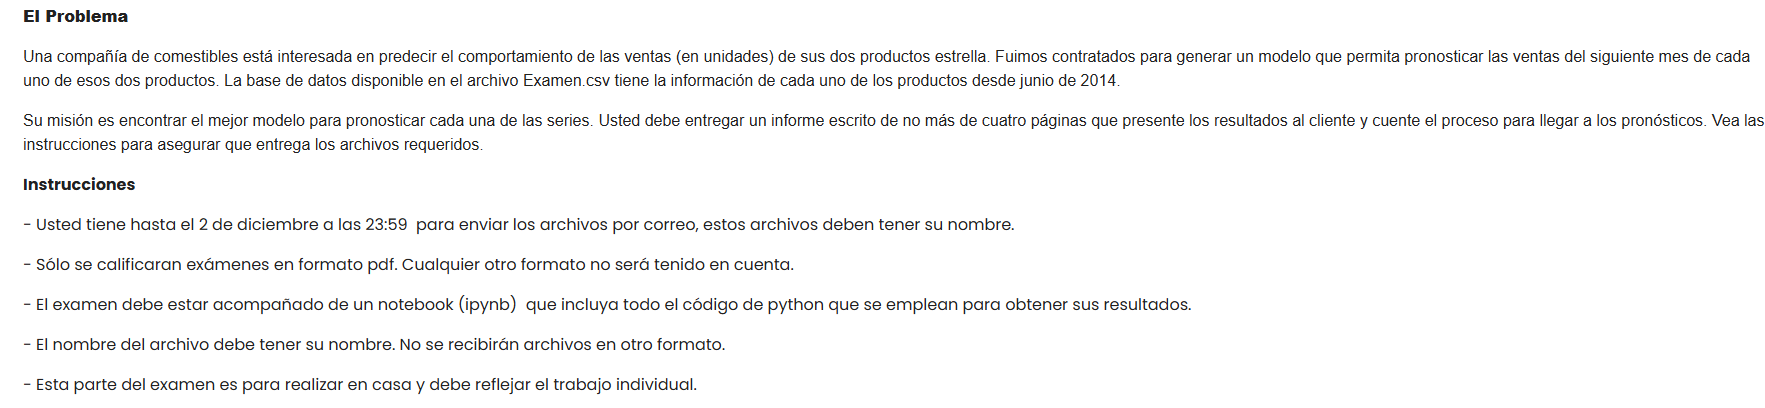

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
import os
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt

## Análisis del dataset Original

In [2]:
main_dir = os.path.dirname(os.getcwd())
inputs_dir = os.path.join(main_dir,"inputs")
outputs_dir = os.path.join(main_dir, "outputs")
html_dir = os.path.join(outputs_dir, "html")
png_dir = os.path.join(outputs_dir, "png")
models_dir = os.path.join(outputs_dir,  "models")
os.makedirs(html_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [3]:

#modificar el nombre de la columna index aqui
df_original=pd.read_csv(os.path.join(inputs_dir,'Examen.csv'), parse_dates=True)
df_original
df_original.info


<bound method DataFrame.info of      Unnamed: 0   producto1   producto2
0             1  500.000000  200.000000
1             2  497.400893  210.686220
2             3  478.605317  222.018584
3             4  486.454125  233.920990
4             5  479.695678  238.402098
..          ...         ...         ...
122         123  164.610771  629.293034
123         124  150.881839  637.099467
124         125  151.788470  653.155282
125         126  137.047639  672.528345
126         127  141.990873  676.058092

[127 rows x 3 columns]>

Se observa que la empresa de comestibles tiene un conjunto de datos de 127 meses que inicia desde el mes 06 del 2014 con 3 columnas/caracteristicas con las unidades vendidas de cada uno de los 2 productos por mes.

## Análisis Exploratorio (EDA)

In [4]:
print("\n--- DataFrame Description --- ")
print(df_original.describe())


--- DataFrame Description --- 
       Unnamed: 0   producto1   producto2
count  127.000000  127.000000  127.000000
mean    64.000000  343.571660  581.037664
std     36.805797  100.234821  167.504363
min      1.000000  137.047639  200.000000
25%     32.500000  256.853812  469.194001
50%     64.000000  340.644019  626.048401
75%     95.500000  450.071775  708.941718
max    127.000000  500.000000  806.440615


En el análisis estadístico de las características del dataset, se observa que la primer columna corresponde al mes; para el `producto1` hay un promedio de unidades vendidas de `343.57` con una desviación estandar de `100.23`, el mes que menos se vendió fueron `137.04` unidades y el mes que más se vendió fue de `500` unidades. Así mismo se evaluó el `producto2` donde se observó un promedio de `581` unidades en los `127` meses con una desviación estandar de `167.50`, el mes que menos se vendió fue de `200` unidades y el mes que más vendió fue de `806.44`.

In [5]:

df = df_original.copy()

df["Unnamed: 0"] = pd.date_range(start='2014-06-01', periods=len(df), freq='MS')
df.rename(columns={"Unnamed: 0": "mes"}, inplace=True)
print(df.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   mes        127 non-null    datetime64[ns]
 1   producto1  127 non-null    float64       
 2   producto2  127 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.1 KB
None


In [6]:
df

,mes,producto1,producto2
0,2014-06-01,500.000000,200.000000
1,2014-07-01,497.400893,210.686220
2,2014-08-01,478.605317,222.018584
3,2014-09-01,486.454125,233.920990
4,2014-10-01,479.695678,238.402098
...,...,...,...
122,2024-08-01,164.610771,629.293034
123,2024-09-01,150.881839,637.099467
124,2024-10-01,151.788470,653.155282
125,2024-11-01,137.047639,672.528345


## Funciones de visualización de las series de tiempo y su descomposición

In [7]:
def plot_time_series(
    df,
    date_col,
    value_col,
    x_label="Fecha",
    y_label="Valor",
    title="Serie Temporal",
    html_path="eda.html",
    png_path="eda.png"
):

    df[date_col] = pd.to_datetime(df[date_col])
    serie = df.set_index(date_col)[value_col]

    media_val = serie.mean()
    min_val = serie.min()
    max_val = serie.max()
    min_date = serie.idxmin()
    max_date = serie.idxmax()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=serie.index, y=serie, mode="lines", name=value_col))
    fig.add_trace(go.Scatter(
        x=serie.index, y=[media_val]*len(serie),
        mode="lines", name=f"Media {media_val:.2f}", line=dict(dash="dot")
    ))
    fig.add_trace(go.Scatter(x=[min_date], y=[min_val], mode="markers",
                             marker=dict(size=10, color="red"), name="Mínimo"))
    fig.add_trace(go.Scatter(x=[max_date], y=[max_val], mode="markers",
                             marker=dict(size=10, color="green"), name="Máximo"))
    fig.update_layout(title=title, xaxis_title=x_label, yaxis_title=y_label,
                      paper_bgcolor="white", plot_bgcolor="white")
    fig.write_html(html_path)
    plt.figure(figsize=(12,6))
    plt.plot(serie.index, serie.values, label=value_col, color="blue")
    plt.axhline(media_val, linestyle="--", color="orange", label=f"Media {media_val:.2f}")
    plt.scatter(min_date, min_val, color="red", s=70, label=f"Mínimo {min_val:.2f}")
    plt.scatter(max_date, max_val, color="green", s=70, label=f"Máximo {max_val:.2f}")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=300)
    plt.close()

    return fig

def seasonal_decomposition(
    df,
    date_col,
    value_col,
    model="additive",
    period=None,
    title="Seasonal Decomposition",
    html_path="seasonal_decomposition.html",
    png_path="seasonal_decomposition.png"
):

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)

    result = seasonal_decompose(df[value_col], model=model, period=period)
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=["Serie Original", "Tendencia", "Estacionalidad", "Residuo"]
    )
    fig.add_trace(go.Scatter(x=df.index, y=result.observed, mode="lines"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=result.trend, mode="lines"), row=1, col=2)
    fig.add_trace(go.Scatter(x=df.index, y=result.seasonal, mode="lines"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=result.resid, mode="lines"), row=2, col=2)

    fig.update_layout(title=title, height=900, width=1300,
                      paper_bgcolor="white", plot_bgcolor="white")
    fig.write_html(html_path)
    plt.figure(figsize=(14,10))

    plt.subplot(2,2,1)
    plt.plot(df.index, result.observed, color="blue")
    plt.title("Serie Original")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(2,2,2)
    plt.plot(df.index, result.trend, color="orange")
    plt.title("Tendencia")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(2,2,3)
    plt.plot(df.index, result.seasonal, color="green")
    plt.title("Estacionalidad")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(2,2,4)
    plt.plot(df.index, result.resid, color="red")
    plt.title("Residuo")
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(png_path, dpi=300)
    plt.close()

    return fig

## EDA para el producto 1 y su comportamiento a través del tiempo

In [8]:
# Se grafica la serie temporal de la columna "producto1"
plot_time_series(
    df=df,
    date_col="mes",
    value_col="producto1",
    x_label="Fecha",
    y_label="Producto1",
    title="",
    html_path=os.path.join(html_dir, "EDA_Producto1.html"),png_path=os.path.join(html_dir, "EDA_Producto1.png")
)

In [9]:
seasonal_decomposition(
    df=df,
    date_col="mes",
    value_col="producto1",
    model="additive",
    period=12,
    html_path=os.path.join(html_dir, "seasonal_decompose_Producto1.html"),
    png_path=os.path.join(png_dir, "seasonal_decompose_Producto1.png"),title=''
)

Se observa que la serie del producto 1 presenta una tendencia general decreciente, aunque con un repunte temporal entre 2021 y 2022.

En cuanto a la estacionalidad, esta muestra un patrón cíclico anual que inicia su ascenso en mayo hasta alcanzar su máximo global en julio. Posteriormente, decrece hasta diciembre. A inicios de año, se observa una leve recuperación en enero seguida de una caída hasta marzo, para repuntar brevemente en abril antes de volver a bajar en mayo.

In [10]:
def optimize_ets_mw(df, date_col, value_col,
                    initial_train_size=48,
                    forecast_horizon=6,
                    step_size=6):
    series = df[value_col]
    n = len(series)

    errors    = [None,"additive", "multiplicative"]
    trends    = [None, "additive", "multiplicative"]
    seasonals = [None, "additive", "multiplicative"]

    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    results = {}

    for error in errors:
        for trend in trends:
            for seasonal in seasonals:

                rmses = []

                for start in range(0, 
                                   n - initial_train_size - forecast_horizon + 1, 
                                   step_size):

                    train = series.iloc[start:start + initial_train_size].values
                    test  = series.iloc[start + initial_train_size:
                                        start + initial_train_size + forecast_horizon].values

                    try:
                        model = ETSModel(
                            endog=train,
                            error=error,
                            trend=trend,
                            seasonal=seasonal
                        ).fit()

                        pred = model.forecast(forecast_horizon)

                    except:
                        rmses.append(np.nan)
                        continue

                    if (np.any(np.isnan(pred)) or 
                        np.any(np.isinf(pred)) or
                        np.any(np.abs(pred) > 1e10)):
                        rmses.append(np.nan)
                    else:
                        rmses.append(rmse(test, pred))
                valid_rmses = [x for x in rmses if not np.isnan(x)]
                avg_rmse = np.mean(valid_rmses) if valid_rmses else np.inf

                results[(error, trend, seasonal)] = avg_rmse

    best = min(results, key=results.get)
    best_rmse = results[best]

    return {
        "best_params": {
            "error": best[0],
            "trend": best[1],
            "seasonal": best[2]
        },
        "best_rmse": best_rmse,
        "all_results": results
    }
def rolling_ets_results(df, date_col, value_col, params,
                        initial_train_size,
                        forecast_horizon,
                        step_size):
    series = df[value_col]
    n = len(series)

    metrics = []

    error = params["error"]
    trend = params["trend"]
    seasonal = params["seasonal"]

    for start in range(0, n - initial_train_size - forecast_horizon + 1, step_size):

        train = series.iloc[start:start + initial_train_size].values
        test  = series.iloc[start + initial_train_size:
                            start + initial_train_size + forecast_horizon].values

        window_start = series.index[start]
        window_end   = series.index[start + initial_train_size - 1]

        try:
            model = ETSModel(
                endog=train,
                error=error,
                trend=trend,
                seasonal=seasonal
            ).fit()

            pred = model.forecast(forecast_horizon)

            rmse = np.sqrt(mean_squared_error(test, pred))

        except:
            rmse = np.nan

        metrics.append({
            "window_start": window_start,
            "window_end": window_end,
            "rmse": rmse
        })

    return pd.DataFrame(metrics)
def plot_ets_rmse_interactive(results_df, html_path="ets_rmse.html", png_path="ets_rmse.png"):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=results_df["window_end"],
        y=results_df["rmse"],
        mode="lines+markers",
        marker=dict(size=8),
        line=dict(width=2),
        name="RMSE"
    ))

    fig.update_layout(
        title="RMSE por ventana móvil (ETS - mejor modelo)",
        xaxis_title="Fin de ventana de entrenamiento",
        yaxis_title="RMSE",
        template="plotly_white",
        width=1000,
        height=600
    )

    fig.write_html(html_path)
    fig.write_image(png_path)

    fig.show()

In [14]:
resultado = optimize_ets_mw(
    df=df,
    date_col="mes",
    value_col="producto1",
    initial_train_size=48,
    forecast_horizon=6,
    step_size=1
)
best_params = resultado["best_params"]
ets_results = rolling_ets_results(
    df=df,
    date_col="mes",
    value_col="producto1",
    params=best_params,
    initial_train_size=48,
    forecast_horizon=6,
    step_size=6
)

In [15]:
plot_ets_rmse_interactive(
    results_df=ets_results,
    html_path=os.path.join(html_dir, "ets_rmse.html"),
    png_path=os.path.join(png_dir, "ets_rmse.png")
)

In [16]:
ets_model = ETSModel(
    endog=df["producto1"].values,
    error=best_params["error"],
    trend=best_params["trend"],
    seasonal=best_params["seasonal"]
).fit()

In [17]:
serie = df.set_index("mes")["producto1"] 
model_arima = auto_arima(
    serie,
    start_p=1, max_p=3,
    start_d=0, max_d=1,
    start_q=1, max_q=3,
    start_P=1, max_P=3,
    start_D=0, max_D=1,
    start_Q=1, max_Q=3,
    m=12,                
    seasonal=True,
    trace=True,          
    stepwise=True,       
    error_action="ignore",
    suppress_warnings=True
)

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Docume

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=927.006, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=930.868, Time=0.11 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=930.870, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=935.958, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=928.971, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=928.928, Time=0.05 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=929.302, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=928.919, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=928.966, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=915.551, Time=0.06 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=917.480, Time=0.20 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=917.427, Time=0.19 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=870.702, Time=0.07 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=872.702, Time=0.26 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=872.701, Time=0.17 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=874.230, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=875.267, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=868.542, Time=0.10 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=870.488, Time=0.32 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(0,0,1)[12] intercept   : AIC=870.477, Time=0.34 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(1,0,1)[12] intercept   : AIC=872.370, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=867.742, Time=0.08 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=869.664, Time=0.18 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=869.637, Time=0.15 sec


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=871.304, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=867.821, Time=0.04 sec

Best model:  ARIMA(3,1,0)(0,0,0)[12] intercept
Total fit time: 4.716 seconds


d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [18]:
order = model_arima.order
seasonal_order = model_arima.seasonal_order
m = model_arima.seasonal_order[3]

In [19]:
from pmdarima.arima import ARIMA
initial_train_size = 48   
forecast_horizon = 6      
step_size = 6   
window_end = []
rmse_list = []
n = len(serie)
for start in range(0, n - initial_train_size - forecast_horizon + 1, step_size):

    train = serie.iloc[start : start + initial_train_size]
    test  = serie.iloc[start + initial_train_size :
                       start + initial_train_size + forecast_horizon]

    model = ARIMA(order=order, seasonal_order=seasonal_order)
    model.fit(train)
    pred = model.predict(forecast_horizon)

    rmse = np.sqrt(mean_squared_error(test, pred))
    rmse_list.append(rmse)
    fecha_final = serie.index[start + initial_train_size - 1]
    window_end.append(fecha_final)

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personale

In [20]:
results_arima = pd.DataFrame({
    "window_end": window_end,
    "rmse": rmse_list
})
results_arima = results_arima.sort_values("window_end")

# Plotly interactivo
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_arima["window_end"],
    y=results_arima["rmse"],
    mode="lines+markers",
    marker=dict(size=8),
    line=dict(width=2),
    name="RMSE"
))

fig.update_layout(
    title="RMSE por ventana móvil (AutoARIMA - mejor modelo)",
    xaxis_title="Fin de ventana de entrenamiento",
    yaxis_title="RMSE",
    template="plotly_white",
    width=1100,
    height=600,
    xaxis=dict(
        tickformat="%Y-%m",     # formato YYYY-MM
        tickangle=45            # rotar etiquetas
    )
)

# Guardar archivos
fig.write_html(os.path.join(html_dir, "autoarima_rmse.html"))
fig.write_image(os.path.join(png_dir, "autoarima_rmse.png"))

fig.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

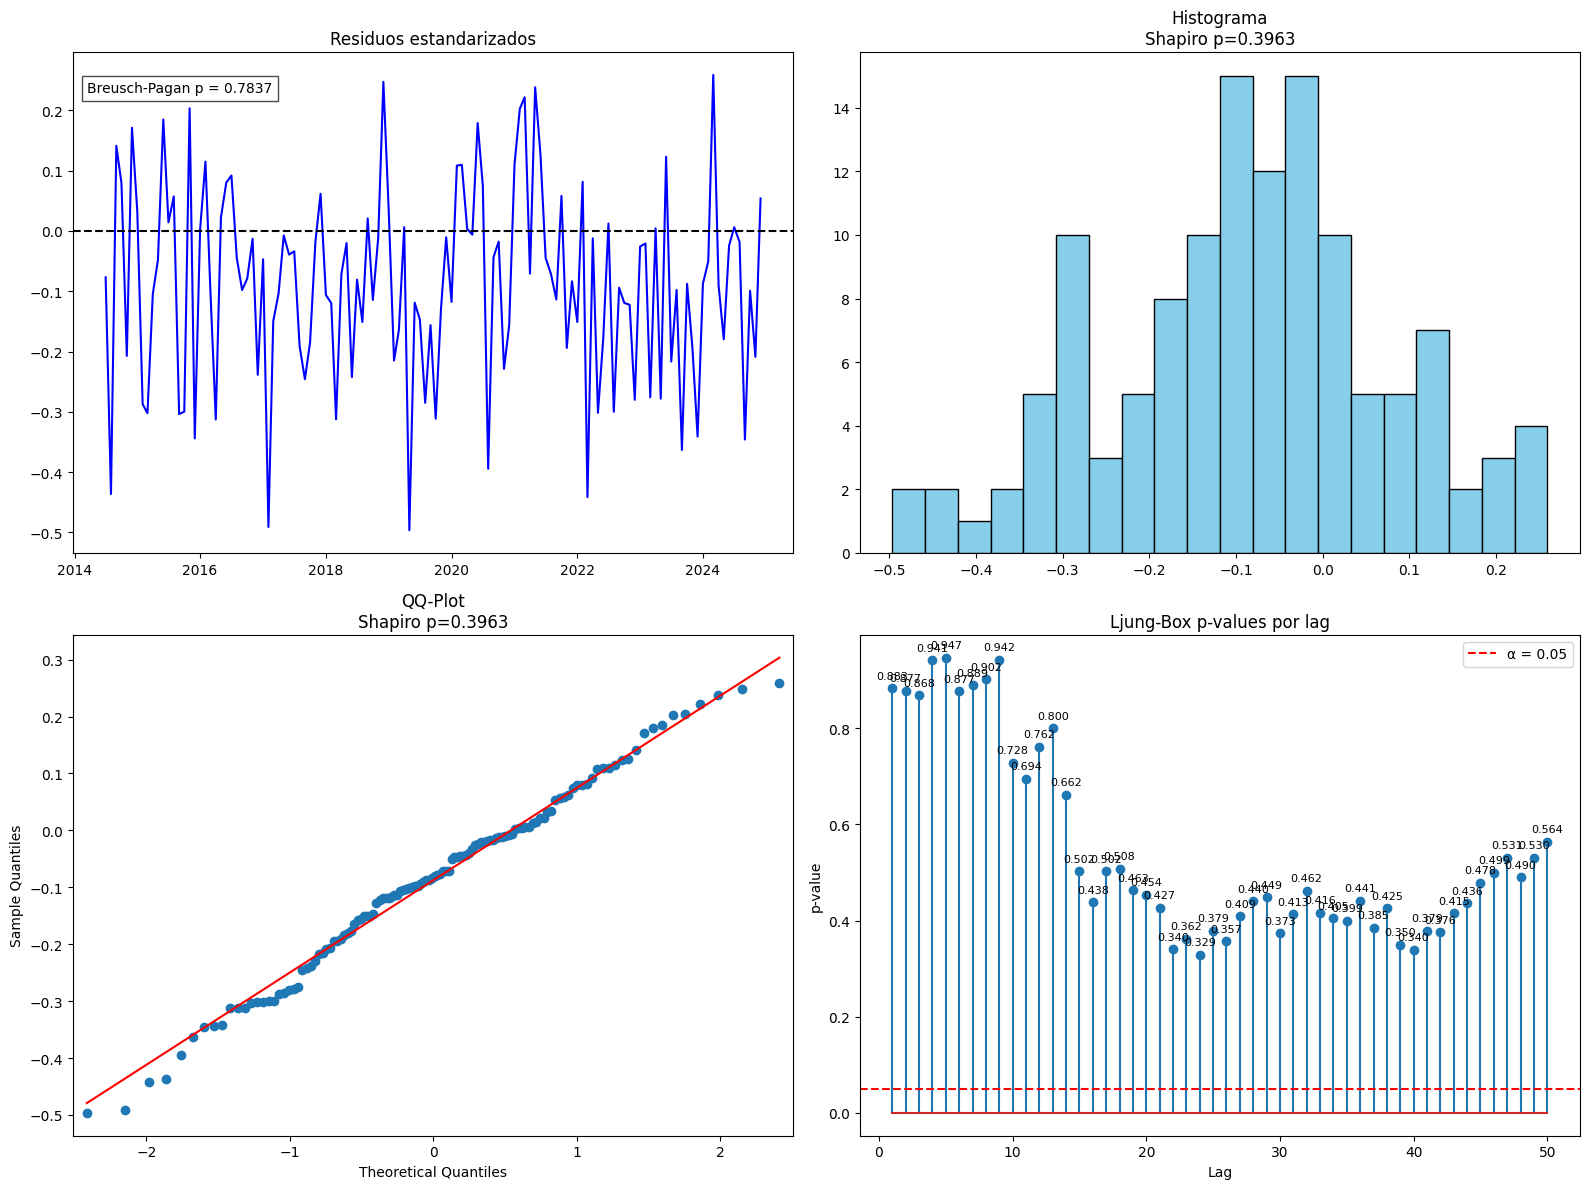

In [33]:
residuals = model_arima.resid()
resid_std = (residuals - np.mean(residuals)) / np.std(residuals)
resid_std = resid_std[1:]
shapiro_stat, shapiro_p = stats.shapiro(resid_std)
lb = acorr_ljungbox(resid_std, lags=50, return_df=True)
lb_stat = lb["lb_stat"].values
lb_pvalues = lb["lb_pvalue"].values.astype(float)   
X = np.column_stack([
    np.ones(len(resid_std)),
    np.arange(len(resid_std))
])
bp_stat, bp_p, _, _ = het_breuschpagan(resid_std, X)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0, 0].plot(resid_std, color="blue")
ax[0, 0].axhline(0, linestyle="--", color="black")
ax[0, 0].set_title("Residuos estandarizados")
ax[0, 0].text(
    0.02, 0.92,
    f"Breusch-Pagan p = {bp_p:.4f}",
    transform=ax[0, 0].transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7)
)
ax[0, 1].hist(resid_std, bins=20, color="skyblue", edgecolor="black")
ax[0, 1].set_title(f"Histograma\nShapiro p={shapiro_p:.4f}")
qqplot(resid_std, line='s', ax=ax[1, 0])
ax[1, 0].set_title(f"QQ-Plot\nShapiro p={shapiro_p:.4f}")
lags = np.arange(1, 51)
ax[1, 1].stem(lags, lb_pvalues)
ax[1, 1].set_title("Ljung-Box p-values por lag")
ax[1, 1].set_xlabel("Lag")
ax[1, 1].set_ylabel("p-value")
ax[1, 1].axhline(0.05, color="red", linestyle="--", label="α = 0.05")
ax[1, 1].legend()
for lag, p in zip(lags, lb_pvalues):
    ax[1, 1].text(lag, p + 0.02, f"{p:.3f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [23]:
model_arima = ARIMA(order=order, seasonal_order=seasonal_order)
model_arima.fit(serie)

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



,order,"(3, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


In [24]:
fitted_arima = model_arima.predict_in_sample()
fitted_ets = ets_model.fittedvalues
rmse_arima = np.sqrt(mean_squared_error(serie[1:], fitted_arima[1:]))
rmse_ets   = np.sqrt(mean_squared_error(serie, fitted_ets))
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=serie.index,
    y=serie.values,
    mode='lines',
    name='Serie original',
    line=dict(color='black')
))
fig.add_trace(go.Scatter(
    x=serie.index,
    y=fitted_arima[1:],
    mode='lines',
    name=f'SARIMA (2,1,0)(1,0,1) — RMSE={rmse_arima:.2f}',
    line=dict(color='red', dash='dot')
))
fig.add_trace(go.Scatter(
    x=serie.index,
    y=fitted_ets,
    mode='lines',
    name=f'ETS (fitted) — RMSE={rmse_ets:.2f}',
    line=dict(color='blue', dash='dash')
))
y_min = min(serie.min(), fitted_arima[1:].min(), fitted_ets.min())
y_max = max(serie.max(), fitted_arima.max(), fitted_ets.max())
margen = 0.05 * (y_max - y_min)
fig.update_layout(
    title="Serie Original vs Ajustes ARIMA y ETS",
    xaxis_title="Fecha",
    yaxis_title="Ocupados",
    template="plotly_white",
    width=1200,
    height=650,
    yaxis=dict(
        range=[y_min - margen, y_max + margen],  
        autorange=False
    )
)
fig.show()

In [26]:
fitted_arima = pd.Series(model_arima.predict_in_sample(), index=serie.index)
fitted_ets   = pd.Series(ets_model.fittedvalues, index=serie.index)

ultimo_anio = serie.last('12M')

forecast_index = pd.date_range(
    serie.index[-1] + pd.DateOffset(months=1),
    periods=1,
    freq='MS'
)

forecast_arima = pd.Series(model_arima.predict(n_periods=1), index=forecast_index)
forecast_ets   = pd.Series(ets_model.forecast(1), index=forecast_index)

forecast_arima_plot = pd.concat([
    pd.Series([fitted_arima.iloc[-1]], index=[fitted_arima.index[-1]]),
    forecast_arima
])

forecast_ets_plot = pd.concat([
    pd.Series([fitted_ets.iloc[-1]], index=[fitted_ets.index[-1]]),
    forecast_ets
])

serie_plot = pd.concat([
    ultimo_anio,
    pd.Series([ultimo_anio.iloc[-1]], index=[ultimo_anio.index[-1]])
])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=serie_plot.index,
    y=serie_plot.values,
    mode="lines",
    name="Serie original",
    line=dict(color="black")
))

fig.add_trace(go.Scatter(
    x=fitted_arima.loc[ultimo_anio.index].index,
    y=fitted_arima.loc[ultimo_anio.index].values,
    mode="lines",
    name="SARIMA (2,1,0)(1,0,1)",
    line=dict(color="red", dash="dot")
))

fig.add_trace(go.Scatter(
    x=fitted_ets.loc[ultimo_anio.index].index,
    y=fitted_ets.loc[ultimo_anio.index].values,
    mode="lines",
    name="ETS",
    line=dict(color="blue", dash="dash")
))

fig.add_trace(go.Scatter(
    x=forecast_arima_plot.index,
    y=forecast_arima_plot.values,
    mode="lines+markers",
    name="Forecast SARIMA",
    line=dict(color="red")
))

fig.add_trace(go.Scatter(
    x=forecast_ets_plot.index,
    y=forecast_ets_plot.values,
    mode="lines+markers",
    name="Forecast ETS",
    line=dict(color="blue")
))

fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Producto1",
    template="plotly_white",
    width=1200,
    height=650
)

fig.show()

C:\Users\jorozco\AppData\Local\Temp\ipykernel_18608\3888196204.py:4: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

C:\Users\jorozco\AppData\Local\Temp\ipykernel_18608\3888196204.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [28]:
arima_forecast, arima_ci = model_arima.predict(n_periods=1, return_conf_int=True)
forecast_arima = pd.Series(arima_forecast, index=forecast_index)
arima_df = pd.DataFrame(
    np.column_stack([arima_forecast, arima_ci]),
    index=forecast_index,
    columns=["point", "lower", "upper"]
)

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

d:\iProveedor\Documentos_personales\Maestria_AI\ICESI\AA3\AA3_Series_de_Tiempo\venv310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [29]:
arima_df.to_excel(os.path.join(outputs_dir,'forecast_producto1.xlsx'),index=False)

## EDA para el producto 2 y su comportamiento a través del tiempo

In [11]:
# Se grafica la serie temporal de la columna "producto2"
plot_time_series(
    df=df,
    date_col="mes",
    value_col="producto2",
    x_label="Fecha",
    y_label="producto2",
    title="",
    html_path=os.path.join(html_dir, "EDA_producto2.html"),png_path=os.path.join(html_dir, "EDA_producto2.png")
)

In [12]:
seasonal_decomposition(
    df=df,
    date_col="mes",
    value_col="producto2",
    model="additive",
    period=12,
    html_path=os.path.join(html_dir, "seasonal_decompose_Producto2.html"),
    png_path=os.path.join(png_dir, "seasonal_decompose_Producto2.png"),title=''
)